# A simple language model to classify Kaggle essays according to grade.

In [1]:
import caffe
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import cohen_kappa_score as CKS
from sklearn.metrics import confusion_matrix
from scipy.stats.stats import pearsonr
from sklearn.manifold import TSNE
%matplotlib inline
plt.rcParams['figure.figsize'] = (14,8)

In [2]:
caffe.set_mode_cpu()

# The weights are from a model trained using a word embedding pre-trained using CBoW.
# Use aes_skpgrm.caffemodel for weights from a model learned using a skip-gram pre-trained word embedding.
# Use aes_skpgrm_neg.caffemodel for weights from a model learned using a skip-gram with negative sampling pre-trained word embedding.

model_def = 'aes_deploy.prototxt'
model_weights = 'aes_cbow.caffemodel' 
net = caffe.Net(model_def,  model_weights,  caffe.TEST)

In [3]:
for layer_name, blob in net.blobs.items():
    print (layer_name + '\t' + str(blob.data.shape))

data	(100, 161)
label	(100,)
wrd2vec	(100, 161, 100)
FC1	(100, 200)
pred	(100, 5)
probs	(100, 5)


In [4]:
for layer_name, param in net.params.items():
    print (layer_name + '\t' + str(param[0].data.shape) + str(param[1].data.shape))

wrd2vec	(701, 100)(100,)
FC1	(200, 16100)(200,)
pred	(5, 200)(5,)


In [5]:
iters = 3
pred = []
labs = []
acts = []
for i in range(iters):
    net.forward()
    for n in range(100):
        pr = np.argmax(net.blobs['probs'].data[n])
        lb = net.blobs['label'].data[n]
        act = list(net.blobs['FC1'].data[n])
        pred.append(pr)
        labs.append(lb)
        acts.append(act)
FC1_activations = np.asarray(acts)

In [6]:
# Quadratic Weighted Kappa is the statistic used to evaluate essay scoring models. This is because human examiners -
# very often differ slightly in the marks they award. Unlike raw accuracy, which weights all errors with zero, Kappa -
# weights small grade discrepancies but gives very little weight to large errors.

print("Quadratic Weighted Kappa:",np.round(CKS(pred,labs,weights='quadratic'),3))

Quadratic Weighted Kappa: 0.657


In [7]:
print("Pearson product-moment correlation:",np.round(pearsonr(pred,labs)[0],3))

Pearson product-moment correlation: 0.68


In [8]:
# Accuracy is often called "exact agreement" in the education literature.
acc = []
for i in range(len(labs)):
    ac = int(pred[i] == labs[i])
    acc.append(ac)
print("Exact Agreement (Accuracy):",np.round(np.sum(acc)/len(acc),3))

Exact Agreement (Accuracy): 0.567


### Visualising hidden layer activations with t-SNE

In [9]:
# t-SNE produces a 2D reduction of the original 200D hidden layer space
tsne = TSNE(n_components=2, random_state=0, n_iter=10000, perplexity=5, learning_rate = 50)
T = tsne.fit_transform(FC1_activations)

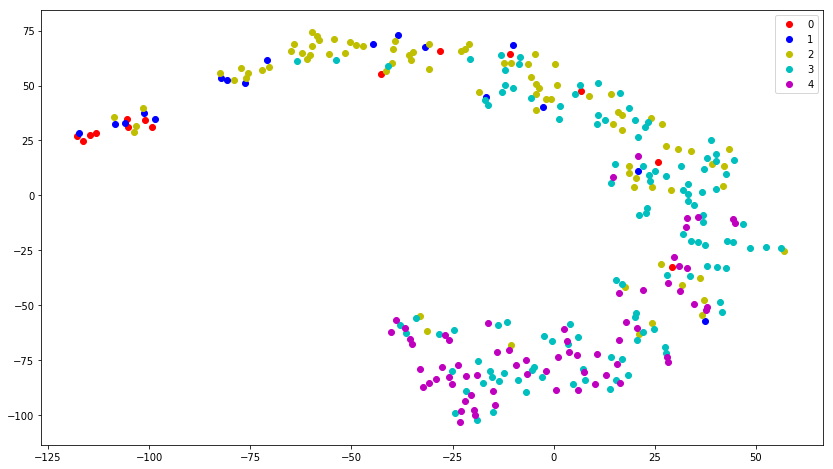

In [10]:
lab_nm = np.asarray(sorted(set(labs)), dtype=np.int32)
lbs = np.asarray(labs)
lab_ids = range(len(lab_nm))
colors = 'r', 'b', 'y', 'c','m'
for i, c, label in zip(lab_ids, colors, lab_nm):
    plt.scatter(T[lbs == i, 0],T[lbs == i, 1],c=c,label=label)
plt.legend()
plt.show()

The model clustered most of the zero graded passages separately from the majority of other documents. Considerable overlap can be seen between passages with adjacent grades, especially for passages with the top grade of four, almost all of which cluster with documents awarded a grade of three.

In [11]:
confusion_matrix(labs,pred)

array([[ 2,  6,  3,  3,  0],
       [ 0,  8,  6,  3,  0],
       [ 0,  7, 39, 36,  3],
       [ 0,  0, 11, 88, 18],
       [ 0,  0,  0, 34, 33]], dtype=int64)

The confusion matrix is consistent with the 2D t-SNE visualisation. Most classification errors were of a score adjacent to the correct label. This is why the Quadratic Weighted Kappa statistic is relatively high - most of the misclassifcation errors lie next to the diagonal.
A more powerful model, a different approach to text pre-processing or more data could be used to improve this result.